# **1. Понимание бизнеса**

## **1.1 Цель**

Предсказать оценку качества вина.

## **1.2 Описание**

Датасет взят с с сайта kaggle. Ссылка: https://www.kaggle.com/datasets/rajyellow46/wine-quality/



Датасет содержит информацию о белом и красном вине в части их физико-химических свойств. Целевая переменная - качество. В этой задаче предлагается осуществить анализ путем применения инструментов машинного обучения, чтобы предсказать по физико-химическим характеристикам вина его качество.

# **2. Data understanding**

## **2.1 Импорт библиотек**

In [1]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.5 MB/s eta 0:00:00


In [2]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import optuna

## **2.2 Загрузка данных**

In [4]:
df = pd.read_csv('/content/wine-quality.zip')

## **2.3 Статистика и визуализации**

**Общий обзор**

In [5]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Переменные:**

*   type (тип вина: белое или красное)
*   fixed acidity
*   volatile acidity
*   citric acid
*   residual sugar
*   chlorides
*   free sulfur dioxide
*   total sulfur dioxide
*   density
*   pH
*   sulphates
*   alcohol




**Некоторая ключевая информация о переменных и статистики**

In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


**Тепловая карта корреляции**

<ipython-input-7-658d61449c58>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(round(df.corr(),2), annot=True, cmap="crest")


<Axes: >

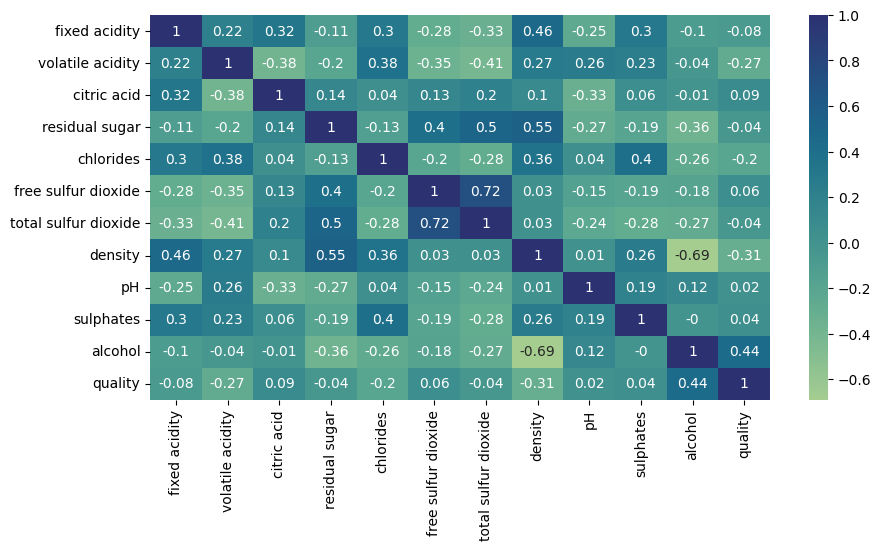

In [7]:
plt.figure(figsize=(10,5))
sns.heatmap(round(df.corr(),2), annot=True, cmap="crest")

По карте корреляции больше всего влияет на оценку признак - алкоголь. Также некоторые признаки сильно связаны между собой (free sulfur dioxide и total sulfur dioxide), но не более 0.72, поэтому на текущем этапе удалять никакие признаки не будем

**Связь оценок и типа вина (красное-белое)**

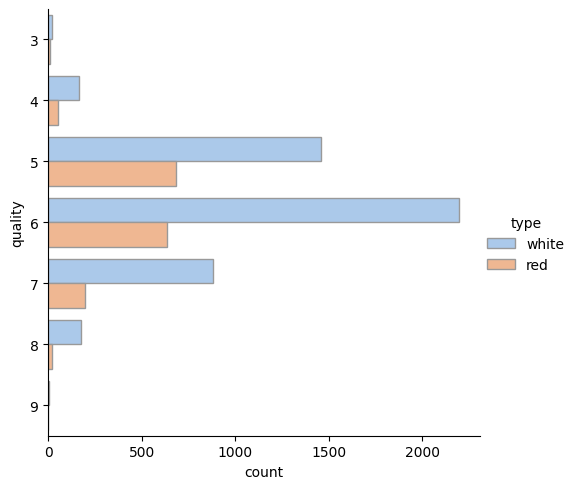

In [8]:
sns.catplot(
    data=df, y="quality", hue="type", kind="count",
    palette="pastel", edgecolor=".6",
)

Особо по графику ничего сказать нельзя кроме того, что белого вина больше, чем красного по оценкам

**Сбалансированность целевой переменной**

<Axes: xlabel='quality', ylabel='Count'>

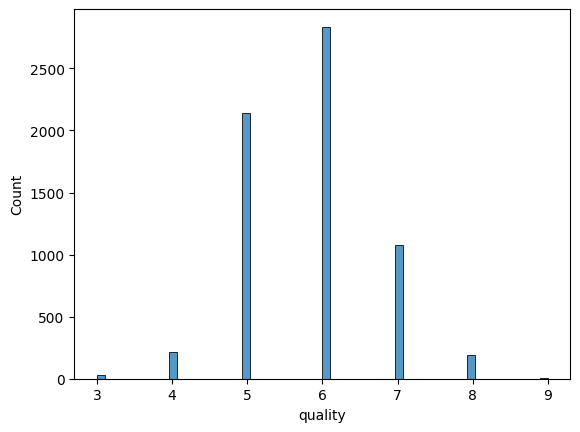

In [9]:
sns.histplot(df['quality'])

Большинство оценок 5-7, очень хорошие или очень плохие оценки очень редки. Возможно, удастся найти какие-то переменные, которые свидетельствуют сразу о высоком/низком качестве вина для использования в дальнейшем. Распределение в целом похоже на нормальное

# **3. Data Preparation**

## **3.1 Обработка признаков**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Категориальные данные - только тип вина

**Переведем единственную категорию (белое/красное) в значения 1/0**

In [11]:
df = pd.get_dummies(df, drop_first=True)

In [12]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


In [13]:
df.isna().sum()

fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
type_white               0
dtype: int64

Пропусков не так много, удалим их

In [14]:
df = df.dropna()

## **3.2 Разделение данных на тренировочные и тестовые**

In [15]:
X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=42)

Для теста оставили 30% данных

# **4. Моделирование**

В зависимости от того, как непосредственно могла быть поставлена задача, можно подходить по-разному: например, классифицировать вино по признакам: среднее-плохое-хорошее. Но в данной задаче мы будем прогнозировать непосредственно оценку качества вина, поэтому будем использовать регрессионные модели и округлять их результаты до целого.

## **4.1. Выбор модели**

Будем использовать 2 основные модели: RandomForesrRegressor с попыткой тюнинга и CatBoostRegressor с базовыми параметрами

**Слачайный лес с подбором параметров с помощью optuna**

In [16]:
def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_features": trial.suggest_float("max_features", 0.1, 1.),
    }

    estimator = RandomForestRegressor(**param, verbose=False, n_jobs=-1)

    estimator.fit(X_train, y_train)
    pred = estimator.predict(X_test)

    return mean_squared_error(y_test, pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)
print(study.best_trial)

[I 2023-10-02 11:23:13,865] A new study created in memory with name: no-name-024232d6-a080-42a2-86ce-a9efd32c0d86
[I 2023-10-02 11:23:26,286] Trial 0 finished with value: 0.3722464889251728 and parameters: {'n_estimators': 614, 'max_features': 0.5704737856421901}. Best is trial 0 with value: 0.3722464889251728.
[I 2023-10-02 11:23:44,474] Trial 1 finished with value: 0.3693108383520669 and parameters: {'n_estimators': 801, 'max_features': 0.3971735862640835}. Best is trial 1 with value: 0.3693108383520669.
[I 2023-10-02 11:24:03,779] Trial 2 finished with value: 0.373624063829027 and parameters: {'n_estimators': 753, 'max_features': 0.6360450930385031}. Best is trial 1 with value: 0.3693108383520669.
[I 2023-10-02 11:24:06,270] Trial 3 finished with value: 0.38335162056486183 and parameters: {'n_estimators': 101, 'max_features': 0.902010851502452}. Best is trial 1 with value: 0.3693108383520669.
[I 2023-10-02 11:24:13,119] Trial 4 finished with value: 0.37452770321244233 and parameters

FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.3648361020318549], datetime_start=datetime.datetime(2023, 10, 2, 11, 24, 40, 811985), datetime_complete=datetime.datetime(2023, 10, 2, 11, 24, 54, 273239), params={'n_estimators': 991, 'max_features': 0.19152013965832498}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=10, value=None)


In [17]:
study.best_params

{'n_estimators': 991, 'max_features': 0.19152013965832498}

**Catboostregressor со стандартными параметрами**

In [18]:
cb = CatBoostRegressor(random_state=42, verbose=False)

## **4.2 Обучение модели**

In [19]:
rf = RandomForestRegressor(random_state=42, n_estimators = study.best_params['n_estimators'], max_features = study.best_params['max_features'])
rf.fit(X_train, y_train)
preds_rf = rf.predict(X_test).round()

In [20]:
cb.fit(X_train, y_train)
preds_cb = cb.predict(X_test).round()

# **5. Оценка**

Оценим результаты модели через среднеквадратичную ошибку не тестовой выборке

In [23]:
print('Ошибка randomforest:', np.sqrt(mean_squared_error(y_test, preds_rf)))
print('Ошибка catboost:', np.sqrt(mean_squared_error(y_test, preds_cb)))

Ошибка randomforest: 0.6463289438526494
Ошибка catboost: 0.6951537836175331


# **6. Развертывание**

Попробуем сначала блендингом улучшить результат (e random forest результат чуть получше, поэтому его предсказание возьмем с большим весом), а потом переобучим модель на полном датасете

In [26]:
total_preds = 0.6 * preds_rf + 0.4 * preds_cb
np.sqrt(mean_squared_error(y_test, total_preds))

0.6386874110837348

Ошибка немного уменьшилась

In [27]:
rf.fit(X, y)
cb.fit(X, y)

Дальше пре поступлении новых данных о вине, мы добавляем их в две модели и блендим:

total_prediction = 0.6 * rf.predict(new_data).round() + 0.4 * cb.predict(new_data).round()

# **Отчет**

**Что было сделано и краткие выводы:**

Был проанализирован dataset kaggle "Wine Quality" с использованием подхода CRISP-DM.

Построена модель предсказания оценки качества вина на основе его физико-химических свойств.

Проведена оценка модели по качеству предсказаний (среднеквадратичное отклонение 0.64).

Модель переобучена на полном датасете для прогнозирования оценки качества вина по новым данным.

**Возможные дальнейшие шаги**

Необдходима бизнес-оценка качества прогнозного значения оценки вина. Кроме того возможно более бизнес-полезно будет решить задачу классификации, переведя вино в категории плохое-нормальное-отличное, чтобы по представленным характеристикам отбраковывать плохое вино и максимально отбирать отличное, т.к. оценки 5-7 внутри "нормально" категории с отклонением 1 не так информативны.







